In [59]:
# Add parent directory to Python path for imports
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

# Testing Diffuse with GMM

Gaussian Mixture Models (GMM) have the advangtage of admitting closed form solution for the diffusion processes and the for the posterior sampling task of inverse problems. In this Tutorial we will show how to use Gaussian Mixtures to test Diffuse and illustrate its core components.

## Gaussian Mixture Model (GMM)

A GMM represents a probability distribution as a weighted sum of $K$ Gaussian components:

$$p(x)=\sum_{i=1}^Kw_i\mathcal{N}(x;\mu_i,\Sigma_i)$$

Where:
- $w_i\geq0$, $\sum_iw_i=1$ (mixture weights)
- $\mu_i\in\mathbb{R}^d$ (component means)
- $\Sigma_i\in\mathbb{R}^{d\times d}$ (component covariance matrices)

In [60]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

# Import GMM utilities
from examples.gaussian_mixtures.mixture import MixState, pdf_mixtr, sampler_mixtr

# Create mixture by hand for clarity
weights = jnp.array([0.6, 0.4])
means = jnp.array([[0.0, 0.0], [2.0, 2.0]])
covariances = jnp.array([jnp.eye(2) * 0.5, jnp.eye(2) * 0.8])

mix_state = MixState(weights=weights, means=means, covariances=covariances)

print("Created 2D GMM:")
print(f"  Component 1: weight={weights[0]}, mean={means[0]}")
print(f"  Component 2: weight={weights[1]}, mean={means[1]}")

# Sample from mixture
key = jax.random.PRNGKey(42)
samples = sampler_mixtr(key, mix_state, 500)

print(f"\nSampled {len(samples)} points")
print(f"Sample mean: {jnp.mean(samples, axis=0)}")

# Create PDF grid
x_range = jnp.linspace(-2, 4, 50)
y_range = jnp.linspace(-2, 4, 50)
X, Y = jnp.meshgrid(x_range, y_range)
grid_points = jnp.stack([X.ravel(), Y.ravel()], axis=1)

pdf = lambda x: pdf_mixtr(mix_state, x)
# Evaluate PDF on grid
pdf_values = jax.vmap(pdf)(grid_points)
pdf_grid = pdf_values.reshape(X.shape)


Created 2D GMM:
  Component 1: weight=0.6, mean=[0. 0.]
  Component 2: weight=0.4, mean=[2. 2.]

Sampled 500 points
Sample mean: [0.72069293 0.71951714]


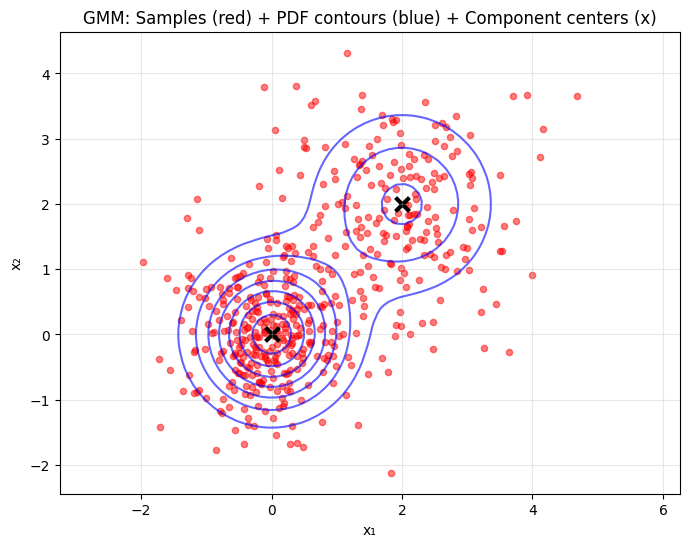

In [61]:
# Plot samples with PDF contours
plt.figure(figsize=(8, 6))
plt.contour(X, Y, pdf_grid, levels=8, colors='blue', alpha=0.6, linewidths=1.5)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=20, c='red')
plt.scatter(means[:, 0], means[:, 1], c='black', s=100, marker='x', linewidth=3)
plt.title('GMM: Samples (red) + PDF contours (blue) + Component centers (x)')
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## Closed-Form Solution for GMM + Diffusion

Given an initial data distribution $x_0 \sim \text{GMM}$, i.e., $p_0(x_0) = \sum_i w_i \mathcal{N}(x_0; \mu_i(0), \Sigma_i(0))$, where $\sum_i w_i = 1$ and $w_i \geq 0$, and a diffusion process defined by $x_t = s(t) x_0 + \sigma(t) \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, I)$, the diffused distribution $p_t(x_t)$ is also a Gaussian Mixture Model (GMM).

The diffused distribution is given by:
$$p_t(x_t) = \sum_i w_i \mathcal{N}(x_t; \mu_i(t), \Sigma_i(t))$$

Where:
- **Mean**: $\mu_i(t) = s(t) \mu_i(0)$
- **Covariance**: $\Sigma_i(t) = s(t)^2 \Sigma_i(0) + \sigma(t)^2 I$
- **Weights**: $w_i(t) = w_i(0)$ (weights remain unchanged)

**Note**: The covariance expression assumes a general diffusion process. In specific diffusion models (e.g., variance-preserving diffusions like DDPM), the noise schedule may define $\sigma(t)^2 = 1 - s(t)^2$, leading to $\Sigma_i(t) = s(t)^2 \Sigma_i(0) + (1 - s(t)^2) I$. 



In [62]:
# Import diffusion components
from diffuse.diffusion.sde import LinearSchedule, SDE
from examples.gaussian_mixtures.mixture import rho_t, transform_mixture_params

# Create SDE with linear schedule
beta = LinearSchedule(b_min=0.02, b_max=7.0, t0=0.0, T=1.0)
sde = SDE(beta=beta)

# Time evolution from t=0 to t=1
time_points = jnp.array([0.0, 0.3, 0.6, 1.0])

# Transform mixture at all times using vmap
transform_at_times = jax.vmap(lambda t: transform_mixture_params(mix_state, sde, t))
mixtures_at_times = transform_at_times(time_points)

# Sample from all transformed mixtures using vmap
keys = jax.random.split(jax.random.PRNGKey(123), len(time_points))
sample_at_times = jax.vmap(lambda k, mix: sampler_mixtr(k, mix, 300))
samples_at_times = sample_at_times(keys, mixtures_at_times)

# Create PDF grid once
grid_points = jnp.stack([X.ravel(), Y.ravel()], axis=1)

# Evaluate PDF for all mixtures at once using vmap
evaluate_pdf = jax.vmap(lambda mix: jax.vmap(lambda x: pdf_mixtr(mix, x))(grid_points))
pdf_values_all = evaluate_pdf(mixtures_at_times)  # (n_times, n_grid_points)

# Reshape all PDF grids
pdf_grids = pdf_values_all.reshape(len(time_points), X.shape[0], X.shape[1])

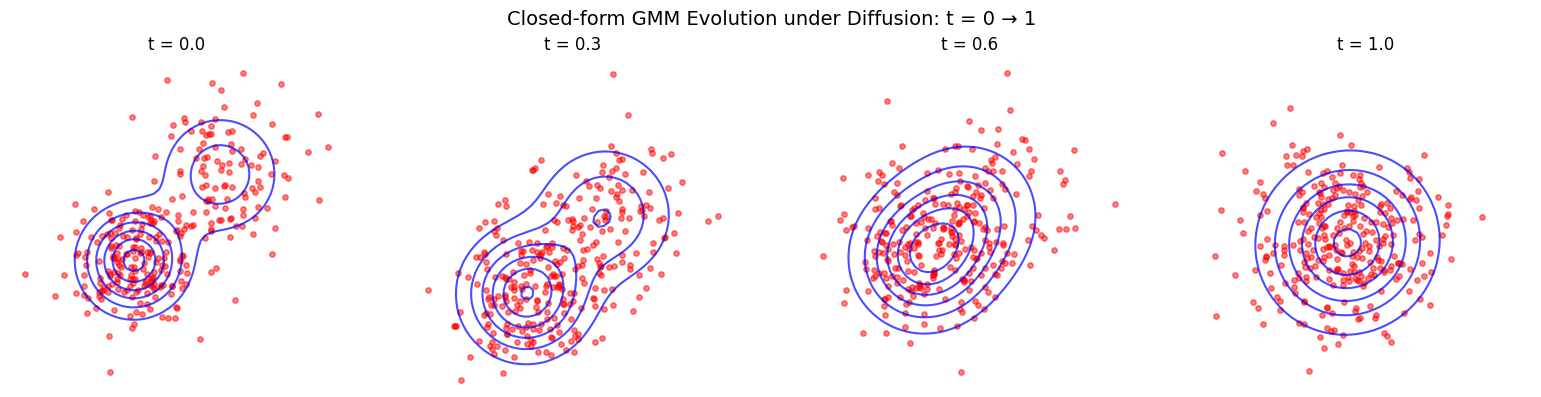

In [63]:
# Create line of plots
fig, axes = plt.subplots(1, len(time_points), figsize=(16, 4))
fig.suptitle('Closed-form GMM Evolution under Diffusion: t = 0 → 1', fontsize=14)

for i, t in enumerate(time_points):
    ax = axes[i]

    # Plot using pre-computed values
    ax.contour(X, Y, pdf_grids[i], levels=6, colors='blue', alpha=0.7, linewidths=1.5)
    ax.scatter(samples_at_times[i, :, 0], samples_at_times[i, :, 1], alpha=0.5, s=15, c='red')

    ax.set_title(f't = {t:.1f}')
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis

    if i == 0:
        ax.set_ylabel('x₂')
    ax.set_xlabel('x₁')

plt.tight_layout()
# Remove the figure background
#fig.patch.set_visible(False)
plt.show()

## Bayesian Posterior with Linear Measurements 

Given a prior distribution $x \sim \text{GMM}$, i.e., $p(x) = \sum_i w_i \mathcal{N}(x; \mu_i, \Sigma_i)$, where $\sum_i w_i = 1$, $w_i \geq 0$, and each component has mean $\mu_i$ and covariance matrix $\Sigma_i$, and a measurement model $y = A x + \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, \sigma_y^2 I)$, the posterior distribution $p(x|y)$ is also a Gaussian Mixture Model (GMM).

The posterior is given by:
$$p(x|y) = \sum_i \bar{w}_i \mathcal{N}(x; \bar{\mu}_i, \bar{\Sigma}_i)$$

Where:
- **Covariance**: $\bar{\Sigma}_i = \left( \Sigma_i^{-1} + \frac{1}{\sigma_y^2} A^T A \right)^{-1}$
- **Mean**: $\bar{\mu}_i = \bar{\Sigma}_i \left( \frac{1}{\sigma_y^2} A^T y + \Sigma_i^{-1} \mu_i \right)$
- **Weights**: $\bar{w}_i \propto w_i \times p(y|\mu_i, \Sigma_i)$, with normalization $\sum_i \bar{w}_i = 1$
- **Likelihood**: $p(y|\mu_i, \Sigma_i) = \mathcal{N}(y; A \mu_i, A \Sigma_i A^T + \sigma_y^2 I)$

This conjugacy property makes GMMs particularly useful for testing and debugging diffusion-based inverse problems, as the posterior can be computed analytically at each step.

In [64]:
from examples.gaussian_mixtures.cond_mixture import compute_posterior

# Simple measurement setup: observe first coordinate
A = jnp.array([[1.0, 0.0]])  # Measure only x[0]
y_observed = jnp.array([1.5])  # Observed x[0] = 1.5
sigma_y = 0.2

print(f"Measurement: y = {y_observed} (observed x[0] = 1.5)")

# Compute Mixture State of the posterior using the closed-form solution
posterior_state = compute_posterior(mix_state, y_observed, A, sigma_y)

# Sample from prior and posterior
key_prior, key_posterior = jax.random.split(jax.random.PRNGKey(789))
prior_samples = sampler_mixtr(key_prior, mix_state, 400)
posterior_samples = sampler_mixtr(key_posterior, posterior_state, 400)

# Compute prior PDF
prior_pdf = jax.vmap(lambda x: pdf_mixtr(mix_state, x))(grid_points)
prior_pdf_grid = prior_pdf.reshape(X.shape)

# Compute posterior PDF
posterior_pdf = jax.vmap(lambda x: pdf_mixtr(posterior_state, x))(grid_points)
posterior_pdf_grid = posterior_pdf.reshape(X.shape)

Measurement: y = [1.5] (observed x[0] = 1.5)


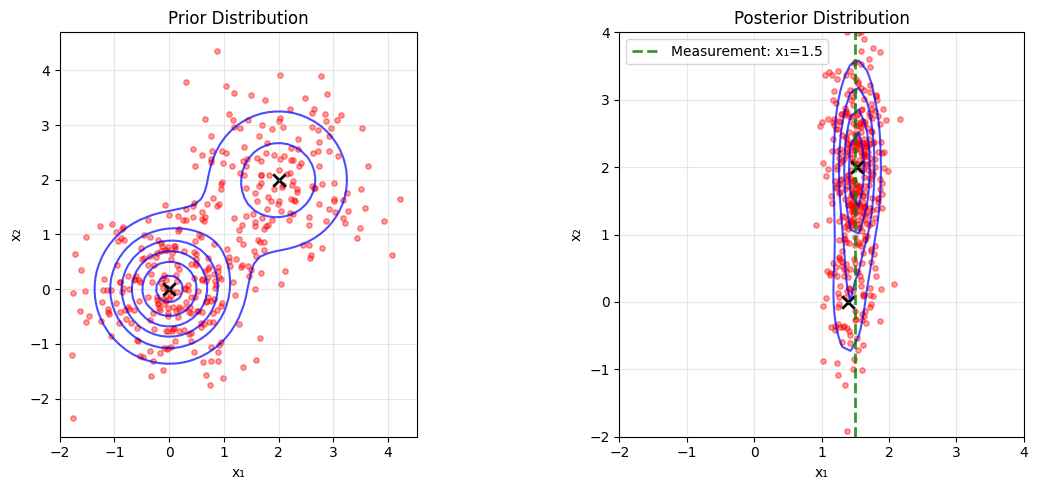

Posterior x₁ mean: 1.50 (should be ≈ 1.5)


In [65]:
# Create 1x2 plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.contour(X, Y, prior_pdf_grid, levels=6, colors='blue', alpha=0.7, linewidths=1.5)
ax1.scatter(prior_samples[:, 0], prior_samples[:, 1], alpha=0.4, s=15, c='red')
ax1.scatter(mix_state.means[:, 0], mix_state.means[:, 1], c='black', s=80, marker='x', linewidth=2)
ax1.set_title('Prior Distribution')
ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

ax2.contour(X, Y, posterior_pdf_grid, levels=6, colors='blue', alpha=0.7, linewidths=1.5)
ax2.scatter(posterior_samples[:, 0], posterior_samples[:, 1], alpha=0.4, s=15, c='red')
ax2.scatter(posterior_state.means[:, 0], posterior_state.means[:, 1], c='black', s=80, marker='x', linewidth=2)

# Add measurement line x[0] = 1.5
ax2.axvline(x=y_observed[0], color='green', linestyle='--', linewidth=2, alpha=0.8, label=f'Measurement: x₁={y_observed[0]}')

ax2.set_title('Posterior Distribution')
ax2.set_xlabel('x₁')
ax2.set_ylabel('x₂')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(-2, 4)
ax2.set_ylim(-2, 4)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"Posterior x₁ mean: {jnp.mean(posterior_samples[:, 0]):.2f} (should be ≈ {y_observed[0]})")

# Unconditional Generation with Diffuse

We demonstrate unconditional generation using different integrators. The `Denoiser` class starts from pure noise and generates samples by integrating the backward SDE using various numerical schemes.

In [86]:
# Import necessary components for generation
from diffuse.denoisers.denoiser import Denoiser
from diffuse.integrator.deterministic import EulerIntegrator, DDIMIntegrator
from diffuse.timer import VpTimer

def pdf(x, t):
    return rho_t(x, t, init_mix_state=mix_state, sde=sde)

# Setup score function for our GMM
def score(x, t):
    grad, val = jax.value_and_grad(pdf)(x, t)
    return grad / val

# Setup timer and integrators
timer = VpTimer(eps=1e-5, tf=sde.tf, n_steps=50)
euler_integrator = EulerIntegrator(sde=sde, timer=timer)
ddim_integrator = DDIMIntegrator(sde=sde, timer=timer)

# Create denoisers with different integrators
euler_denoiser = Denoiser(
    integrator=euler_integrator,
    sde=sde,
    score=score,
    x0_shape=(2,)
)

ddim_denoiser = Denoiser(
    integrator=ddim_integrator,
    sde=sde,
    score=score,
    x0_shape=(2,)
)

# Generate samples using both integrators
key_euler, key_ddim = jax.random.split(jax.random.PRNGKey(456), 2)
n_samples = 500
n_steps = 50

# Euler integration
euler_state, euler_hist = euler_denoiser.generate(key_euler, n_steps, n_samples)
print(f"Generated {n_samples} samples using Euler integrator")

# DDIM integration
ddim_state, ddim_hist = ddim_denoiser.generate(key_ddim, n_steps, n_samples)
print(f"Generated {n_samples} samples using DDIM integrator")

Generated 500 samples using Euler integrator
Generated 500 samples using DDIM integrator


# Conditional Generation with FPS

We demonstrate conditional generation using FPS (Forward Posterior Sampling) via the `CondDenoiser` class. This allows us to generate samples conditioned on measurements $y$, solving inverse problems of the form $x_0 \sim p(x_0|y)$.

In [ ]:
# Import conditional generation components
from diffuse.denoisers.cond import FPSDenoiser
from diffuse.base_forward_model import MeasurementState
from examples.gaussian_mixtures.forward_models.matrix_product import MatrixProduct

# Create measurement state for conditioning
y_measurement = jnp.array([1.5])  # Same measurement as before
forward_model = MatrixProduct(A=A, std=sigma_y)
measurement_state = MeasurementState(y=y_measurement, mask_history=A)

# Create FPS denoiser for conditional generation
fps_denoiser = FPSDenoiser(
    integrator=euler_integrator,
    sde=sde,
    score=score,
    forward_model=forward_model,
    x0_shape=(2,),
)

# Generate conditional samples
key_cond = jax.random.PRNGKey(789)
cond_state, cond_hist = fps_denoiser.generate(
    key_cond,
    measurement_state,
    n_steps,
    n_samples
)

print(f"Generated {n_samples} conditional samples using FPS")
print(f"Conditional samples x₁ mean: {jnp.mean(cond_state.integrator_state.position[:, 0]):.3f} (target: {y_measurement[0]})")

Generated 500 conditional samples using FPS
Conditional samples x₁ mean: nan (target: 1.5)
